In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches 
import os
import sys
import itertools
import imageio
import random
import numpy as np
import copy
import cv2

import mot3d
from mot3d.utils import utils
from mot3d.utils import trajectory as utils_traj
from mot3d.weight_functions import (weight_distance_detections_3d, weight_confidence_detections_3d,\
                                    weight_distance_tracklets_3d, weight_confidence_tracklets_3d)   

sys.path.append("../")
from tracking_routines import *
import feeders

In [60]:
config_file = "../config/config_multiview_PETS2009S2L1.yaml"
__c__ = utils.yaml_read(config_file)
__c__['views'] = [
    'View_001',
    'View_003',
    'View_004',
    'View_005',
    'View_006',
    'View_007',
    'View_008'
]

In [32]:
__cfgd__ = copy.deepcopy(__c__['tracking']['detections'])
__cfgd__

{'weight_source_sink': 5,
 'max_jump': 4,
 'verbose': False,
 'weight_distance': {'sigma_distance': 500,
  'sigma_jump': 2,
  'sigma_color_histogram': 0.1,
  'sigma_box_size': 0.1,
  'max_distance': 750,
  'use_color_histogram': False,
  'use_bbox': False},
 'weight_confidence': {'mul': 0, 'bias': 0}}

In [26]:
__cfgd__['max_jump']=6
__cfgd__['weight_distance']['sigma_distance']=750
__cfgd__['weight_distance']['sigma_jump']=2
__cfgd__['weight_distance']['use_color_histogram']=False
__cfgd__['weight_distance']['use_bbox']=False
__cfgd__['weight_distance']['max_distance'] = 500

In [61]:
__Detection__ = mot3d.Detection3D

weight_distance_d = lambda d1, d2 : weight_distance_detections_3d(d1, d2, **__cfgd__['weight_distance'])
weight_confidence_d = lambda d : weight_confidence_detections_3d(d, **__cfgd__['weight_confidence'])        
__compute_trajs__ = lambda detections: compute_trajectories(detections, 
                                                            weight_source_sink=__cfgd__['weight_source_sink'], 
                                                            weight_distance=weight_distance_d, 
                                                            weight_confidence=weight_confidence_d,
                                                            max_jump=__cfgd__['max_jump'],
                                                            verbose=__cfgd__['verbose'])

In [62]:
views = __c__['views']
feeder_name = __c__['feeder']['name']
object_class = __c__['feeder'][feeder_name]['object_class']
feeder = {view:feeders.Feeder[feeder_name](view, **__c__['feeder'][feeder_name]) for view in views}
iterator = {view:iter(feeder[view]) for view in views}

calibration = utils.json_read(__c__['calibration'])

In [63]:

batch_size = 50

for view in views:
    feeder[view].idx = 300

indexes = []
detections = []
for _ in range(batch_size):
    try:
        _idxs,_detections = list(zip(*[next(iterator[view]) for view in views]))
        indexes.append(_idxs[0])
        detections.append({view:d for view,d in zip(views,_detections)})
    except StopIteration:
        done = True   
        break

print("Batch size: {} from index {} to {}".format(len(detections), indexes[0], indexes[-1]))

Batch size: 50 from index 301 to 350


In [49]:
import subprocess

batch_size = 50

for view in views:
    path = "./dumps/frames_{}".format(view)
    utils.mkdir(path)
    
    feeder[view].idx = 300
    for i in range(batch_size):
        
        idx, detections = next(iterator[view])
        img = feeder[view].get_image(idx)
        
        for d in detections:
            xmin, ymin, xmax, ymax = d.bbox
            x,y = d.position
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), [255,0,0], 2)
            img = cv2.circle(img, (int(x), int(y)), 4, [255,0,0], -1)
        imageio.imwrite(os.path.join(path, "frame_{:06d}.jpg".format(idx)), img)
        
    ext = 'jpg'
    fps=10
    output_path=path
    output_video='{}.mp4'.format(view)
    cmd="ffmpeg -framerate {} -pattern_type glob -i '{}/*.{}' -vcodec libx264 -crf 19 -maxrate 3M -bufsize 6M -profile:v high -pix_fmt yuv420p -movflags faststart -vf \"pad=ceil(iw/2)*2:ceil(ih/2)*2\" {} -y".format(fps, output_path, ext, output_video)
    print(cmd)
    out = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True, shell=True)
    for line in out.stdout:
        print(line.strip())

ffmpeg -framerate 10 -pattern_type glob -i './dumps/frames_View_001/*.jpg' -vcodec libx264 -crf 19 -maxrate 3M -bufsize 6M -profile:v high -pix_fmt yuv420p -movflags faststart -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" View_001.mp4 -y
ffmpeg version 3.4.2-2 Copyright (c) 2000-2018 the FFmpeg developers
built with gcc 7 (Ubuntu 7.3.0-16ubuntu2)
configuration: --prefix=/usr --extra-version=2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enabl

Input #0, image2, from './dumps/frames_View_003/*.jpg':
Duration: 00:00:05.00, start: 0.000000, bitrate: N/A
Stream #0:0: Video: mjpeg, yuvj420p(pc, bt470bg/unknown/unknown), 768x576 [SAR 72:72 DAR 4:3], 10 fps, 10 tbr, 10 tbn, 10 tbc
Stream mapping:
Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[swscaler @ 0x55a9c9008900] deprecated pixel format used, make sure you did set range correctly
[libx264 @ 0x55a9c8c6e900] using SAR=1/1
[libx264 @ 0x55a9c8c6e900] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2
[libx264 @ 0x55a9c8c6e900] profile High, level 3.1
[libx264 @ 0x55a9c8c6e900] 264 - core 152 r2854 e9a5903 - H.264/MPEG-4 AVC codec - Copyleft 2003-2017 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=18 lookahead_threads=3 sliced_threads=0 nr=0 d

ffmpeg -framerate 10 -pattern_type glob -i './dumps/frames_View_005/*.jpg' -vcodec libx264 -crf 19 -maxrate 3M -bufsize 6M -profile:v high -pix_fmt yuv420p -movflags faststart -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" View_005.mp4 -y
ffmpeg version 3.4.2-2 Copyright (c) 2000-2018 the FFmpeg developers
built with gcc 7 (Ubuntu 7.3.0-16ubuntu2)
configuration: --prefix=/usr --extra-version=2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enabl

Input #0, image2, from './dumps/frames_View_006/*.jpg':
Duration: 00:00:05.00, start: 0.000000, bitrate: N/A
Stream #0:0: Video: mjpeg, yuvj420p(pc, bt470bg/unknown/unknown), 720x576 [SAR 65:72 DAR 325:288], 10 fps, 10 tbr, 10 tbn, 10 tbc
Stream mapping:
Stream #0:0 -> #0:0 (mjpeg (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[swscaler @ 0x55913361eea0] deprecated pixel format used, make sure you did set range correctly
[libx264 @ 0x559133366900] using SAR=65/72
[libx264 @ 0x559133366900] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2
[libx264 @ 0x559133366900] profile High, level 3.0
[libx264 @ 0x559133366900] 264 - core 152 r2854 e9a5903 - H.264/MPEG-4 AVC codec - Copyleft 2003-2017 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1 chroma_qp_offset=-2 threads=18 lookahead_threads=3 sliced_threads=0 

ffmpeg -framerate 10 -pattern_type glob -i './dumps/frames_View_008/*.jpg' -vcodec libx264 -crf 19 -maxrate 3M -bufsize 6M -profile:v high -pix_fmt yuv420p -movflags faststart -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2" View_008.mp4 -y
ffmpeg version 3.4.2-2 Copyright (c) 2000-2018 the FFmpeg developers
built with gcc 7 (Ubuntu 7.3.0-16ubuntu2)
configuration: --prefix=/usr --extra-version=2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enabl

In [64]:
__cm__ = __c__['matching']
__cm__

{'threads': 24,
 'max_distance': 12,
 'distance_none': 100,
 'n_candidates': 3,
 'n_min_views_clique': 3,
 'verbose': False}

In [87]:
__cm__['n_candidates'] = 3
__cm__['max_distance'] = 12
__cm__['distance_none'] = 25
__cm__['n_min_views_clique'] = 2

In [88]:
from multiview_tracking import MultiviewMatcher

matcher = MultiviewMatcher(views, calibration, __cm__)
detections_3d,_ = matcher.compute(detections)

In [89]:
tracklets = __compute_trajs__(detections_3d)

In [58]:
tracklet_splits = []
for tracklet in tracklets:
    tracklet = utils_traj.interpolate_trajectory(tracklet, attr_names=['position'])
    tracklet_splits += utils_traj.split_trajectory_modulo(tracklet, length=5)

tracklets = utils_traj.remove_short_trajectories(tracklet_splits, th_length=2)

<IPython.core.display.Javascript object>


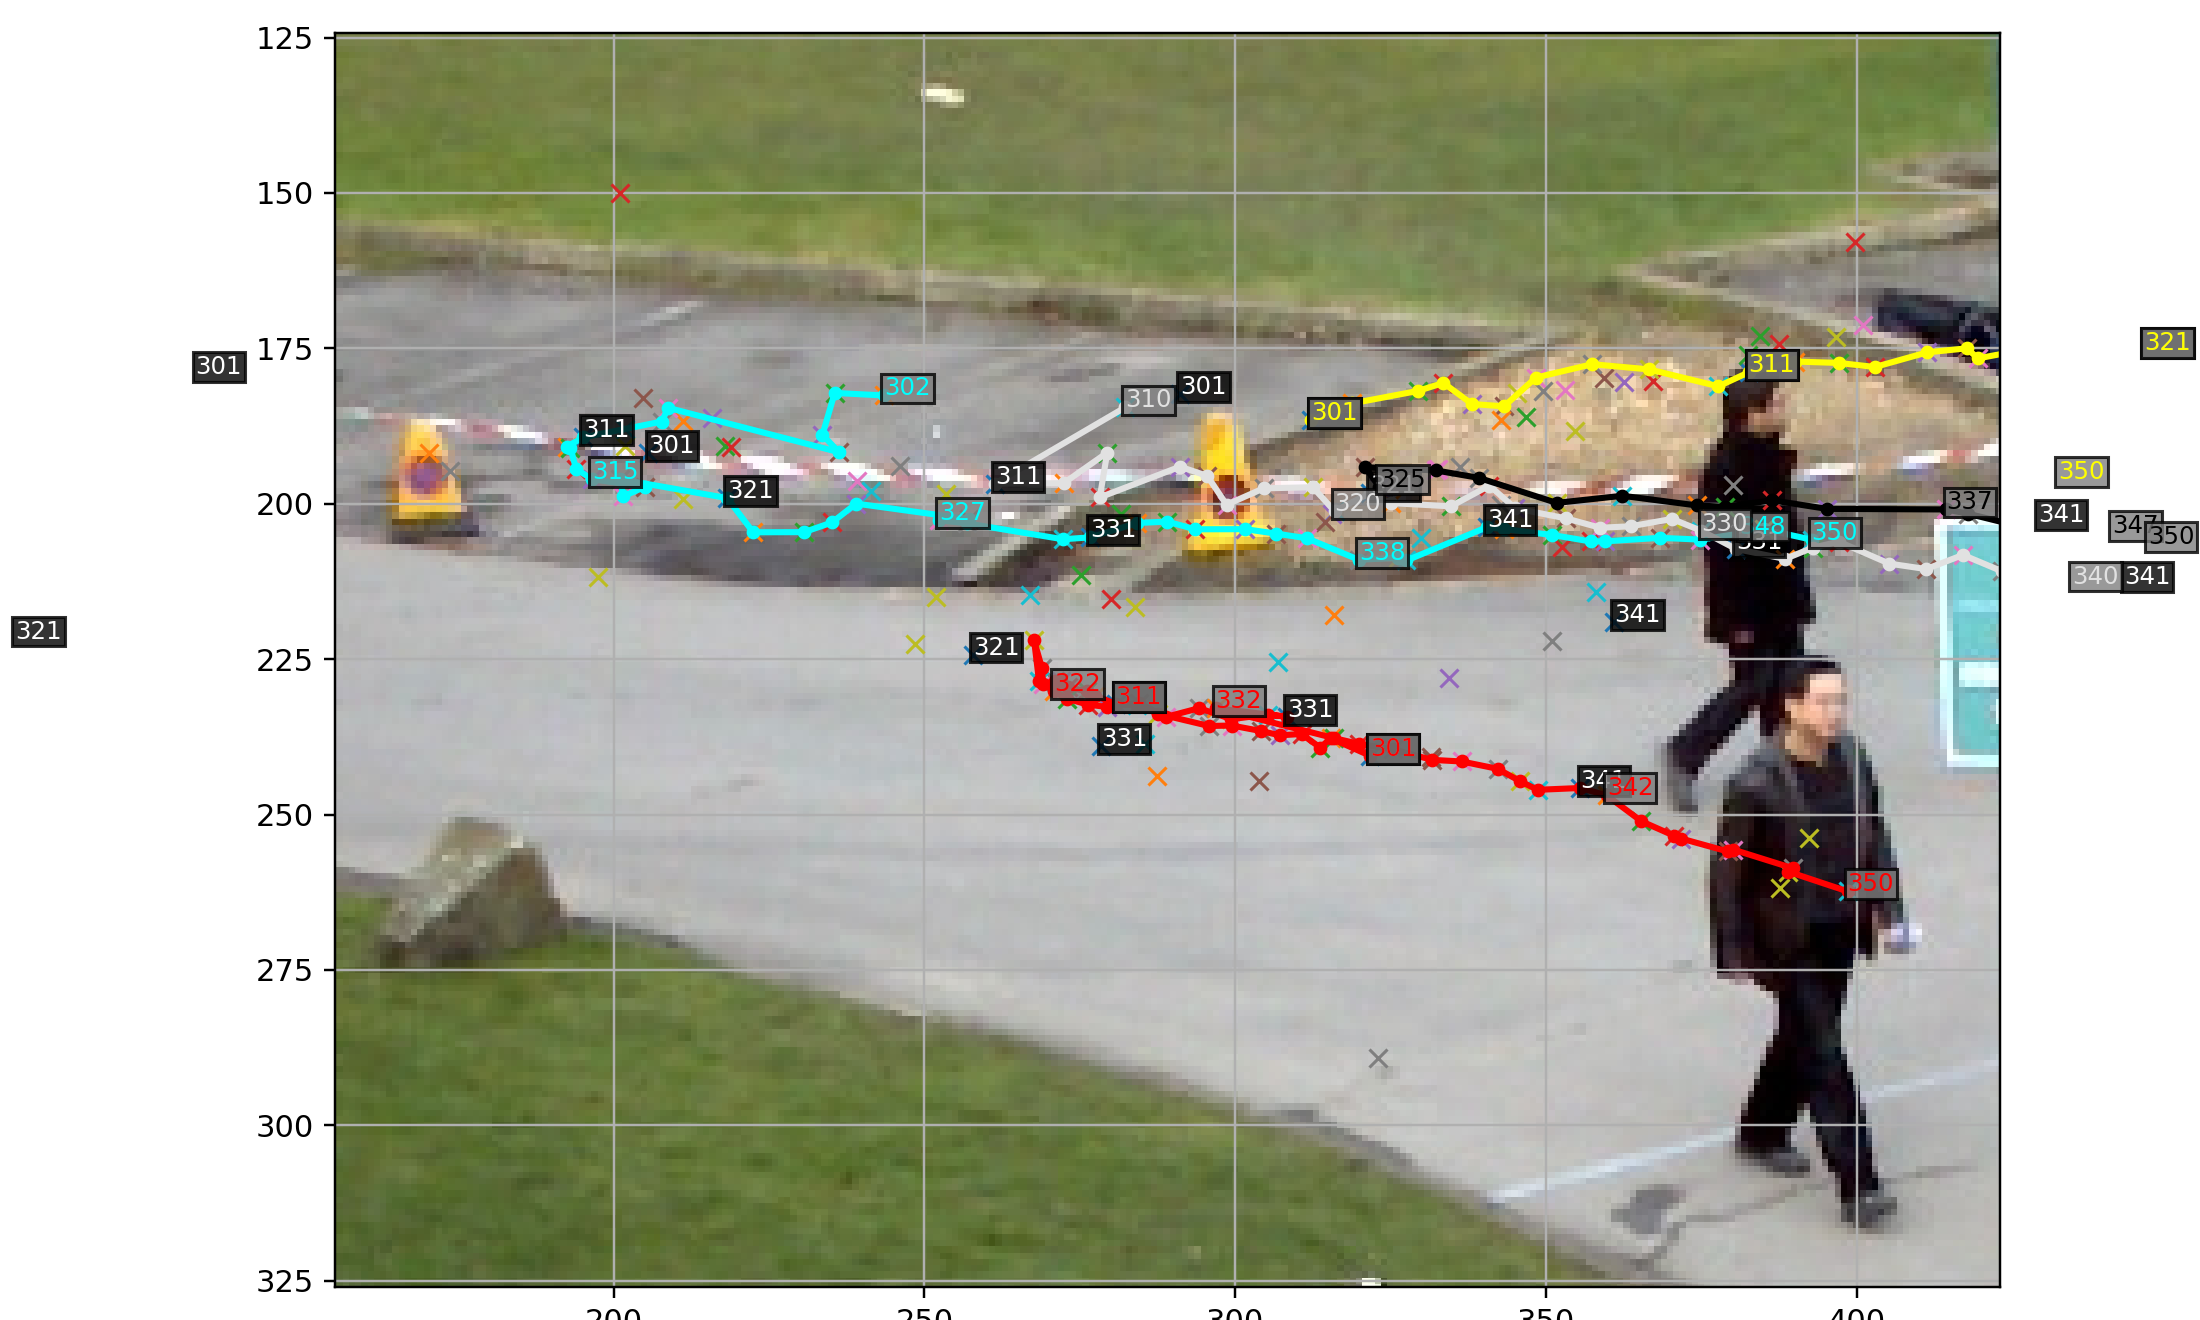

Batch size: 50
0 start_idx:301 end_idx:350 lenght:49 start_pos:[-9768.17067738 -5760.14805906   974.57159157]
1 start_idx:301 end_idx:350 lenght:50 start_pos:[-4016.85952592 -9420.8390189   1171.29278508]
2 start_idx:301 end_idx:350 lenght:48 start_pos:[-3161.3920111  -9981.90348246  1062.45721407]
3 start_idx:301 end_idx:350 lenght:50 start_pos:[-5827.10912298 -2715.42944035  1093.62148205]
4 start_idx:302 end_idx:350 lenght:43 start_pos:[-5598.25151588  -310.20092025   976.40772479]
5 start_idx:302 end_idx:317 lenght:14 start_pos:[-4864.74798816 -8712.40862097  1827.39709785]
6 start_idx:310 end_idx:350 lenght:41 start_pos:[-7274.33868394 -2894.34859758  1443.31994967]
7 start_idx:325 end_idx:350 lenght:24 start_pos:[-10526.96823075  -6399.40030507   2089.93118353]


In [90]:
plt.figure(figsize=(10,6))

view = 'View_001'

def project(positions):
    K = np.array(calibration[view]['K'])
    R = np.array(calibration[view]['R'])
    t = np.array(calibration[view]['t'])
    dist = np.array(calibration[view]['dist'])
    positions = cv2.projectPoints(np.float32(np.reshape(positions,(-1,3))), 
                                  cv2.Rodrigues(R)[0], t, K, dist)[0].reshape(-1,2)   
    return positions

img = feeder[view].get_image(feeder[view].idx-1)
plt.imshow(img)

if True:  
    display_time_every = 10
    
    for dets in detections_3d:
        if len(dets):
            ps = project(np.array([d.position for d in dets]))
            plt.plot(ps[:,0], ps[:,1], 'x')

    for dets in detections_3d[::display_time_every]:    
        positions = project(np.array([d.position for d in dets]))
        times = np.array([d.index for d in dets])
        for (x,y),time in zip(positions, times):
            plt.text(x,y, str(time), color=[1,1,1], fontsize=8, 
                     bbox={'facecolor': 'black', 'alpha': 0.8, 'pad': 1})    

mot3d.plot_trajectories(tracklets, display_time=True, display_time_every=10,
                        calibration=calibration[view])

print("Batch size: {}".format(len(detections_3d)))
for i,tracklet in enumerate(tracklets):
    print("{} start_idx:{} end_idx:{} lenght:{} start_pos:{}".format(i, tracklet[0].index, 
                                                                     tracklet[-1].index,
                                                                     len(tracklet),
                                                                     tracklet[0].position))
plt.tight_layout()